In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


from unidecode import unidecode
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kvidelov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kvidelov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Preprocessing

In [2]:
df_initial_debate = pd.read_csv("../data/us_election_2020_2nd_presidential_debate.csv")

# Making new dataframe which wont have repeating speakers that are the same person

speakers = []
minutes = []
texts = []

for index in range(len(df_initial_debate)-1):

    # debate attributes
    speaker = df_initial_debate.iloc[index].speaker
    minute = df_initial_debate.iloc[index].minute
    current_text = df_initial_debate.iloc[index].text
    next_speaker = df_initial_debate.iloc[index+1].speaker
    next_text = df_initial_debate.iloc[index+1].text

    try:
        # checking if the current speaker is the last speaker
        if speaker == df_initial_debate.iloc[index-1].speaker:
            # checking if the current speaker is also a next speaker
            if speaker == next_speaker:
                texts[-1] += " " + next_text
                continue # skipping to next iteration
            else:
                continue # skipping to next iteration
    
    except: # avoiding for the first row because there cant be previous speaker
            pass 
    
    if speaker == next_speaker: 
        #  combining the text of the current speaker and next if same
        speakers.append(speaker)
        minutes.append(minute)
        texts.append(current_text + " " + next_text)

    else:
        #  text only of current speaker given next one is different
        speakers.append(speaker)
        minutes.append(minute)
        texts.append(current_text)

debate_data = {"speaker":speakers,"minute":minutes,"text":texts}
df_debate = pd.DataFrame(debate_data)

In [3]:
df_debate

,speaker,minute,text
0,Kristen Welker,00:18,"Good evening, everyone. Good evening. Thank yo..."
1,Donald Trump,07:37,How are you doing? How are you?
2,Kristen Welker,07:58,And I do want to say a very good evening to bo...
3,Donald Trump,09:04,"So as you know, 2.2 million people modeled out..."
4,Kristen Welker,11:06,Okay. Former Vice President Biden to you. How ...
...,...,...,...
461,Kristen Welker,24:30,"All right. This is about leadership, gentlemen..."
462,Donald Trump,24:47,We have to make our country totally successful...
463,Kristen Welker,25:49,"All right. Vice President Biden, same question..."
464,Joe Biden,25:57,"I will say, I’m an American President. I repre..."


In [4]:
df_debate['num_words'] = df_debate['text'].str.split().str.len() 

In [5]:
df_grouped_per_candidate = df_debate.groupby('speaker').describe()
df_grouped_per_candidate = df_grouped_per_candidate['num_words'][["count", "mean", "max"]]
df_grouped_per_candidate = df_grouped_per_candidate.rename(columns={"count":"Number of times spoken", "mean": "Average number of words per answer", "max":"Max  number of words used in one answer"})

In [8]:
df_debate.to_csv("../data/debate_preprocessed.csv")

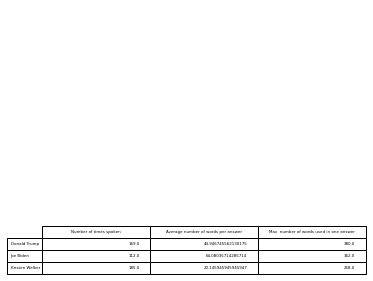

In [6]:
from pandas.plotting import table # EDIT: see deprecation warnings below

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df_grouped_per_candidate)  # where df is your data frame

plt.tight_layout()
plt.savefig('candidates_table.png', dpi=600)

In [7]:
df_candidates = df_debate[df_debate['speaker']!= "Kristen Welker"]

### Making plots

In [8]:
# Preparing colors for the plot
plot_colors = []
for i in df_candidates["speaker"]:
    if i == "Donald Trump":
        plot_colors.append("orange")
    elif i == "Joe Biden":
        plot_colors.append("blue")
    else:
        plot_colors.append("gray")

In [9]:
mins_list = df_candidates['minute'].to_list()

In [10]:
ticks = mins_list[1::15]
tick_labels=[]
for tick in mins_list:

    if tick in ticks and tick not in tick_labels:
        tick_labels.append(tick)
    else:
        tick_labels.append(" ")

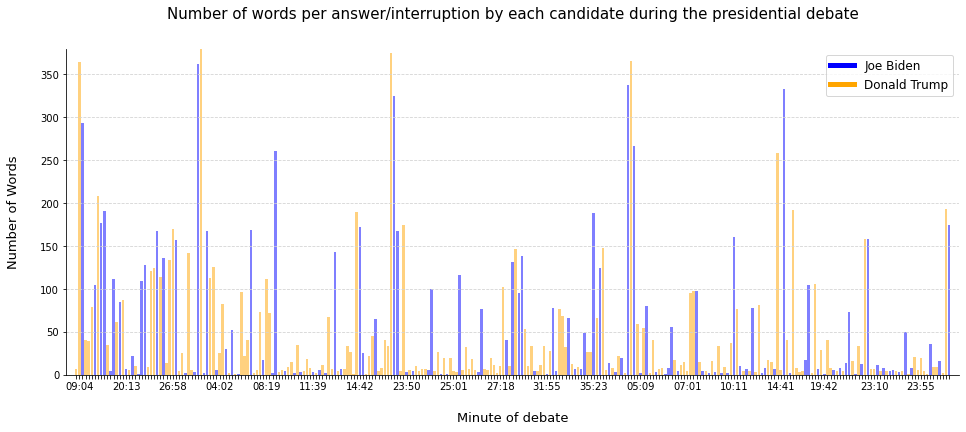

In [11]:
objects = df_candidates['minute']  # x-axis
y_pos = np.arange(len(objects))
performance = df_candidates['num_words']  # y-axis

custom_lines = [Line2D([0], [0], color="blue", lw=5),
                Line2D([0], [0], color="orange", lw=5)]

fig= plt.figure(figsize=(16,6))
ax = fig.add_subplot()
ax.margins(0.01, 0) 
ax.bar(y_pos, performance, color = plot_colors, alpha=0.5)
ax.set_xlabel('Minute of debate', size=13, labelpad=20)
ax.set_ylabel('Number of Words', size=13, labelpad=20)
ax.set_title('Number of words per answer/interruption by each candidate during the presidential debate', fontsize=15, pad=30)
ax.set_xticks(y_pos)#,tick_labels)


ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.set_xticklabels(tick_labels)
#ax.get_xticklabels()[0].set_color("red")
ax.grid(True, axis="y", linestyle="--", color="lightgrey")
ax.legend(custom_lines, ['Joe Biden', 'Donald Trump'],loc=1, prop={'size': 12})

#plt.xticks(range(7), ticks, size="small")
plt.savefig('words_over_time.png', dpi=300)

In [12]:
# stop words 
stop_words = set(stopwords.words('english'))
def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split into words -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = PorterStemmer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # stemm or lemmatise words
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.stem(word)   #dont forget to change stem to lemmatize if you are using a lemmatizer
        stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

In [13]:
df_candidates['prep'] = df_candidates['text'].apply(preprocess)

In [14]:

def filterText(text):
    stopWords = set(stopwords.words('english')) 
    words = word_tokenize(text)
    wordsFiltered = ""
    for w in words: 
        if w not in stopWords and w not in ["!",".",","," ","'","`",'""','’']: 
            wordsFiltered += " " + w
    return wordsFiltered 

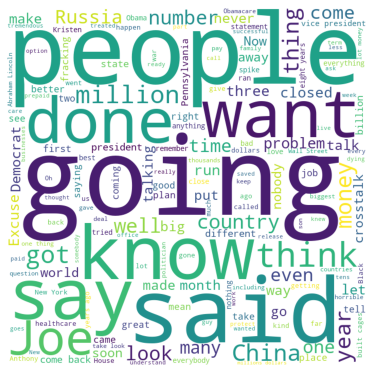

In [15]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
# if uising a Jupyter notebook, include:
%matplotlib inline

all_words = '' 

#looping through all incidents and joining them to one text, to extract most common words
for arg in df_candidates[df_candidates['speaker']=="Donald Trump"]["text"]: 

    
    formatted_arg = filterText(arg)
    tokens = formatted_arg.split()  
      
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.savefig('trump_wc.png', dpi=300)

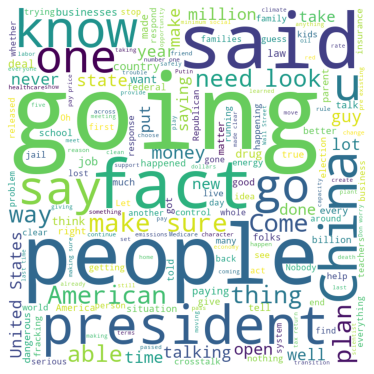

In [16]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
# if uising a Jupyter notebook, include:
%matplotlib inline

all_words = '' 

#looping through all incidents and joining them to one text, to extract most common words
for arg in df_candidates[df_candidates['speaker']=="Joe Biden"]["text"]: 

    
    formatted_arg = filterText(arg)
    tokens = formatted_arg.split()  
      
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.savefig('biden_wc.png', dpi=300)